<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/text_to_3d/point_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Point-e: text to point cloud

In [ ]:
!git clone https://github.com/openai/point-e.git
%cd point-e

In [ ]:
!pip install -q -e .
!pip install -q trimesh

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
import trimesh
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.point_cloud import PointCloud

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_model(model_name):
  print('Creating {} model...'.format(model_name))
  model = model_from_config(MODEL_CONFIGS[model_name], device)
  model.eval()
  if model_name != 'sdf':
    diffusion = diffusion_from_config(DIFFUSION_CONFIGS[model_name])
  else:
    diffusion = None

  print('Downloading {} checkpoint...'.format(model_name))
  model.load_state_dict(load_checkpoint(model_name, device))
  return model, diffusion

In [ ]:
base_model, base_diffusion = create_model('base40M-textvec')
upsampler_model, upsampler_diffusion = create_model('upsample')

In [ ]:
sampler = PointCloudSampler(
    device=device, 
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', '')
)

In [ ]:
prompt = 'a kangaroo'

samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
  samples = x 

0it [00:00, ?it/s]

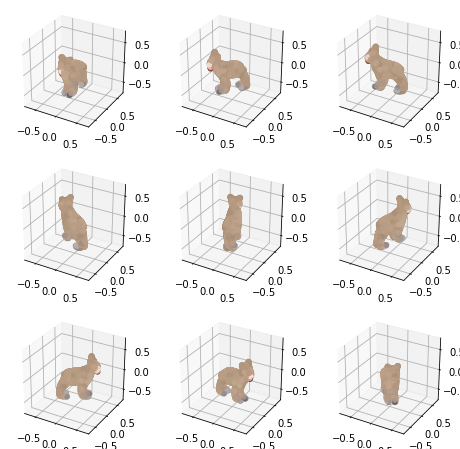

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))

In [ ]:
print(pc.coords.shape)
print(pc.channels.keys())

(4096, 3)
dict_keys(['R', 'G', 'B'])


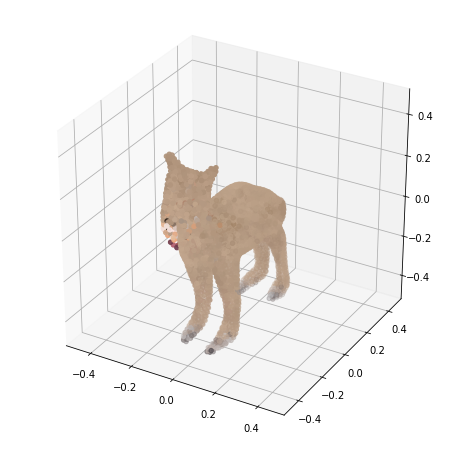

In [ ]:
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.5, -0.5, -0.5), (0.5, 0.5, 0.5)))

##Image to point cloud

In [15]:
# Available models are base40M, base300M, and base1B
base_model, base_diffusion = create_model('base1B')
upsampler_model, upsampler_diffusion = create_model('upsample')

Creating base1B model...


  0%|          | 0.00/4.98G [00:00<?, ?iB/s]

Creating upsample model...


In [16]:
sampler = PointCloudSampler(
    device=device, 
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0]
)

In [61]:
# The file should be located in the point-e folder
img = Image.open('statue.png')

samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
  samples = x 

0it [00:00, ?it/s]

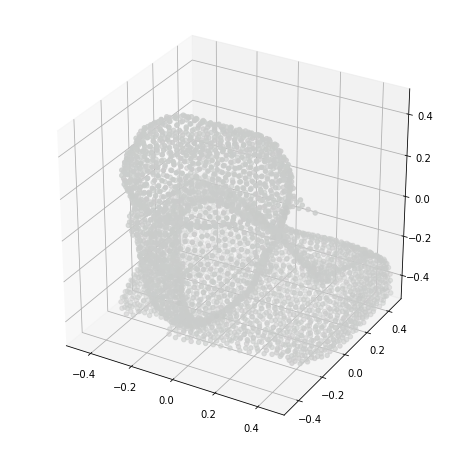

In [62]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.5, -0.5, -0.5), (0.5, 0.5, 0.5)))

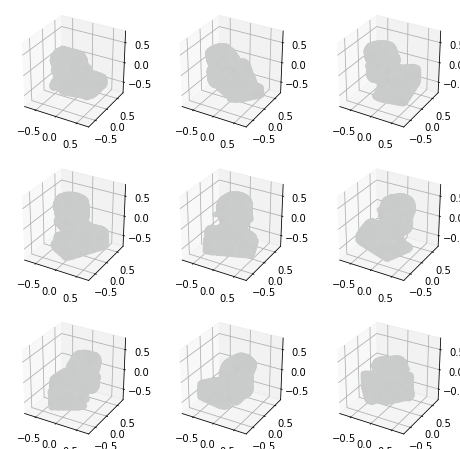

In [63]:
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))

##Point cloud to mesh

In [64]:
pc2mesh_model = create_model('sdf')[0]

Creating sdf model...


In [ ]:
# Optional loading a point cloud from a file
pc2 = PointCloud.load('point_e/examples/example_data/pc_corgi.npz')
fig = plot_point_cloud(pc2, grid_size=2)

In [66]:
import skimage.measure as measure

mesh = marching_cubes_mesh(pc=pc, model=pc2mesh_model, batch_size=4096, 
                           grid_size=32, progress=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [67]:
with open('mesh.ply', 'wb') as f:
  mesh.write_ply(f)

In [ ]:
mesh = trimesh.load_mesh('mesh.ply')
mesh.show()